<a href="https://colab.research.google.com/github/itssofiarce/AAII-TUIA-Alomar-Arce/blob/main/AAII_TUIA_Alomar_Arceipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparación del entorno

In [1]:
!pip install -q gdown

In [2]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Flatten, Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import gdown
import os.path as osp
import zipfile

# TP1-1-student_performance.zip
DATA_TP1_1='https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc'
# TP1-2-diabetes.zip
DATA_TP1_2='https://drive.google.com/uc?id=14-fDOsI9mrosOd-2Pnj8GdP1jyZjUTq_'
# TP1-3-natural-scenes.zip
DATA_TP1_3='https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ'

count=0
while count != 3:
  data = [DATA_TP1_1, DATA_TP1_2, DATA_TP1_3][count]
  # Descargo
  var = gdown.download(data)
  # Extraigo
  with zipfile.ZipFile(f'{var}', 'r') as zip_ref:
    zip_ref.extractall(f'./TP1-{count+1}')

  # Variable que almacena el path de los datasets extraídos
  globals()[f"DATA_DIRECTORY_TP1_{count+1}"] = osp.abspath(f'TP1-{count+1}')

  count += 1


Downloading...
From: https://drive.google.com/uc?id=1mfpXVLqDJah-sO0CF29LjKUz5NtKjZqc
To: /content/TP1-1-student_performance.zip
100%|██████████| 49.7k/49.7k [00:00<00:00, 66.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=14-fDOsI9mrosOd-2Pnj8GdP1jyZjUTq_
To: /content/TP1-2-diabetes.zip
100%|██████████| 9.13k/9.13k [00:00<00:00, 25.8MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=5120bbee-d0fa-4795-8610-094ee9368e5e
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:12<00:00, 29.3MB/s]


Establecer gpu por defecto:


In [4]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Problema 3

Construir modelos de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar las imágenes en las siguientes categorías:
- *buildings*
- *forest*
- *glacier*
- *mountain*
- *sea*
- *street*

Arquitectura de los modelos:

- Modelo con **capas densas**
- Modelo con **capas convolucionales**
- Modelo que  inlcuya **bloques residuales de identidad**
- Modelo que utilice como *backbone* alguna de las arquitecturas disponibles en TensorFlow (*transfer learning*)


In [5]:
# Tamaño del lote (batch size)
BATCH_SIZE = 64
# Tamaño de las imágenes
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    f'{DATA_DIRECTORY_TP1_3}/seg_train/seg_train',
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f'{DATA_DIRECTORY_TP1_3}/seg_test/seg_test',
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 3000 files belonging to 6 classes.
Using 600 files for validation.


In [6]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


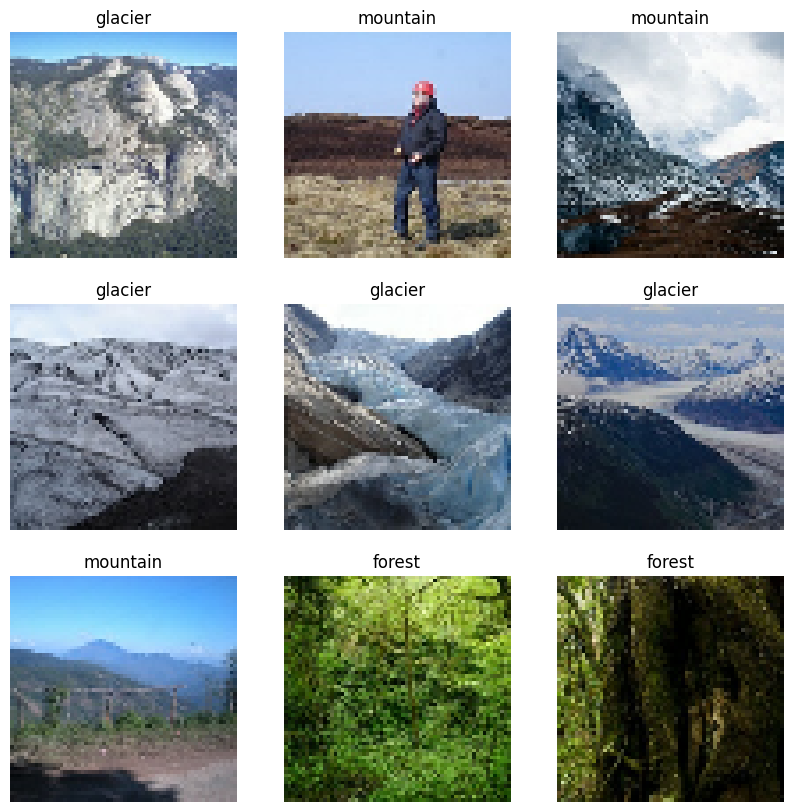

In [7]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

# Preprocesamiento del dataset


## ¿Las clases estan balanceadas?


In [8]:
import os

# Contar la longitud de las carpetas
dataset_dir = f'{DATA_DIRECTORY_TP1_3}/seg_train/seg_train'
class_counts = {}

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):  # Verifica que sea un directorio
        image_count = len(os.listdir(class_path))
        class_counts[class_name] = image_count

# Imprimir los resultados
for class_name, count in class_counts.items():
    print(f'{class_name}: {count} imágenes')


glacier: 2404 imágenes
sea: 2274 imágenes
mountain: 2512 imágenes
street: 2382 imágenes
forest: 2271 imágenes
buildings: 2191 imágenes


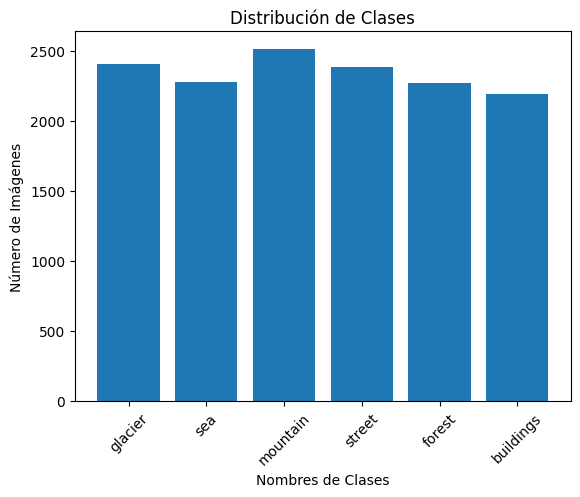

In [9]:
# Bar chart to visualize class distribution
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Nombres de Clases')
plt.ylabel('Número de Imágenes')
plt.title('Distribución de Clases')
plt.xticks(rotation=45)
plt.show()

Las clases tienen un leve desbalanceo predominando la clase *mountain* con 2512 ejemplos de imagenes, mientras que la clase con menor cantidad de samples es la de *buildings* con 2191.




# Modelo convolucional de capas densas

Para el modelo de capas densas, las imagenes fueron normalizadas y pasadas a escalas de grises.

In [10]:
from tensorflow.keras.models import Sequential

In [11]:
def grayscale(image):
    return tf.image.rgb_to_grayscale(image)

train_ds = train_ds.map(lambda image, label: (grayscale(image), label))
val_ds = val_ds.map(lambda image, label: (grayscale(image), label))

In [12]:
# Normalizamos los datos
def normalize(image, label):
  """Normalizes image pixel values."""
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

# Apply the normalization function to each element in the datasets
X_train = train_ds.map(normalize)
X_test = val_ds.map(normalize)

In [13]:
# Modelo de capas densas
model = Sequential([
    Flatten(input_shape=(64, 64)),
    Dense(64, activation='relu'),  # Capa densa intermedia con más neuronas
    Dense(32, activation='relu'),  # Capa existente
    Dense(16, activation='relu'),  # Capa existente
    Dense(6, activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


 Definimos su arquitectura


Compilamos el modelo

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Observamos sus métricas

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         262,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 264,918 (1.01 MB)

 Trainable params: 264,918 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo

In [16]:
# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:567: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.2091 - loss: 31.1908 - val_accuracy: 0.2617 - val_loss: 4.2106
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.2390 - loss: 5.8464 - val_accuracy: 0.2317 - val_loss: 3.8411
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.2545 - loss: 4.2034 - val_accuracy: 0.2083 - val_loss: 6.8118
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - accuracy: 0.2439 - loss: 4.9482 - val_accuracy: 0.2000 - val_loss: 3.9562
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2805 - loss: 2.6256 - val_accuracy: 0.2733 - val_loss: 2.1927
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.2955 - loss: 2.0861 - val_accuracy: 0.2883 - val_loss: 1.9418
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.3413 - loss: 1.7321 - val_accuracy: 0.3300 - val_loss: 1.8087
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.3159 - loss: 1.8021 - val_accuracy: 0.3

Con las redes de capas densas no se llega a un muy buen resultado. Hay overfiting.

# Modelo convolucional de capas convolucionales

Para el modelo de capas convolucionales se les dará como input las imagenes a color y luego en escalas de grises

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [18]:
# Tamaño del lote (batch size)
BATCH_SIZE = 64
# Tamaño de las imágenes
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    f'{DATA_DIRECTORY_TP1_3}/seg_train/seg_train',
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    f'{DATA_DIRECTORY_TP1_3}/seg_test/seg_test',
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 3000 files belonging to 6 classes.
Using 600 files for validation.


In [19]:
num_classes = len(class_names)

# Definición del modelo usando Sequential
model = models.Sequential([

    # Escalado
    layers.Rescaling(1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_HEIGHT,
                                   IMAGE_WIDTH,
                                   3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),

    # Capa convolucional 1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
    layers.MaxPooling2D((2, 2)),

    # Capa convolucional 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Dropout
    layers.Dropout(0.3),

    # Capa convolucional 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Aplanar la salida para las capas densas
    layers.Flatten(),

    # Capa de salida
    layers.Dense(6, activation='softmax')  # 6 categorías
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [20]:
model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 6)                   │          27,654 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,902 (472.27 KB)

 Trainable params: 120,902 (472.27 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Número de épocas de entrenamiento
EPOCHS = 30
# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.4310 - loss: 1.4219 - val_accuracy: 0.6033 - val_loss: 0.9883
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.6312 - loss: 0.9728 - val_accuracy: 0.6233 - val_loss: 0.9624
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.6670 - loss: 0.8784 - val_accuracy: 0.7033 - val_loss: 0.8338
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7015 - loss: 0.8031 - val_accuracy: 0.7367 - val_loss: 0.7519
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7305 - loss: 0.7514 - val_accuracy: 0.7033 - val_loss: 0.8243
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7333 - loss: 0.7241 - val_accuracy: 0.7217 - val_loss: 0.7399
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.7460 - loss: 0.7069 - val_accuracy: 0.7450 - val_loss: 0.6857
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7594 - loss: 0.6696 - val_ac

En las primeras corridas, la red tuvo mucho overfiting:
train_accuracy:75% vs val_accuracy: 73% por lo que se aplicó Dropout para mejorar esos resultados.

76/176 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8337 - loss: 0.4556 - val_accuracy: 0.7900 - val_loss: 0.6188 --> agrego droput



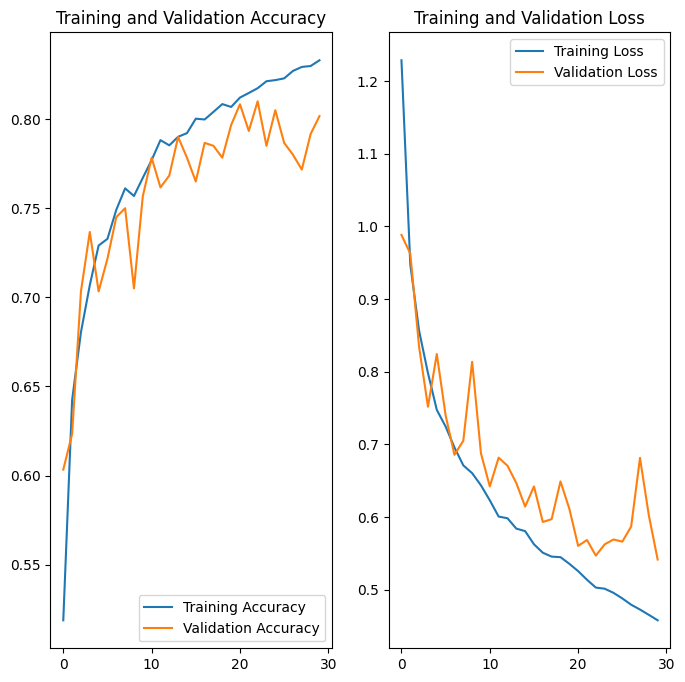

In [23]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Modelo profundo con bloques residuales

In [27]:
def residual_block(x, filters):
    # Primer convolucional
    shortcut = x  # Guarda la entrada para la conexión residual
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)

    # Segundo convolucional
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Ajusta el shortcut si el número de filtros no coincide
    if x.shape[-1] != shortcut.shape[-1]:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)

    # Suma la entrada original (shortcut) con la salida
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x


In [28]:
# Definir el modelo usando Functional API en lugar de Sequential para manejar bloques residuales
inputs = layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))

x = layers.Rescaling(1./255)(inputs)
x = layers.RandomFlip("horizontal")(x)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)

# Primer bloque residual
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 32)

# Segundo bloque residual
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 64)

# Tercer bloque residual
x = layers.MaxPooling2D((2, 2))(x)
x = residual_block(x, 128)

# Aplanar la salida para las capas densas
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(6, activation='softmax')(x)  # 6 categorías

# Crear el modelo funcional
model = models.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 64, 64, 3)      │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_flip_3             │ (None, 64, 64, 3)      │              0 │ rescaling_3[0][0]      │
│ (RandomFlip)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_rotation_3         │ (None, 64, 64, 3)      │              0 │ random_flip_3[0][0]    │
│ (RandomRotation)          │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ random_zoom_3             │ (None, 64, 64, 3)      │              0 │ random_rotation_3[0][… │
│ (RandomZoom)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 64, 64, 32)     │            896 │ random_zoom_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 32, 32, 32)     │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_8     │ (None, 32, 32, 32)     │            128 │ conv2d_14[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_15 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ batch_normalization_8… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 32, 32, 32)     │            128 │ conv2d_15[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 32, 32, 32)     │              0 │ batch_normalization_9… │
│                           │                        │                │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 32, 32, 32)     │              0 │ add_4[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_8           │ (None, 16, 16, 32)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 16, 16, 64)     │         18,496 │ max_pooling2d_8[0][0]  │
├──────────────────────

 Total params: 1,357,958 (5.18 MB)

 Trainable params: 1,357,062 (5.18 MB)

 Non-trainable params: 896 (3.50 KB)

In [29]:
# Compilar el modelo
model.compile(
    optimizer='adam',  # Puedes ajustar el optimizador si es necesario
    loss='categorical_crossentropy',  # O 'sparse_categorical_crossentropy' dependiendo de cómo estén etiquetadas tus clases
    metrics=['accuracy']  # Métricas para monitorear
)

# Número de épocas de entrenamiento
EPOCHS = 30

# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)

Epoch 1/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.3786 - loss: 2.0489 - val_accuracy: 0.1967 - val_loss: 2.7935
Epoch 2/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.5593 - loss: 1.1180 - val_accuracy: 0.4400 - val_loss: 1.6505
Epoch 3/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.5989 - loss: 1.0150 - val_accuracy: 0.6283 - val_loss: 0.9474
Epoch 4/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.6222 - loss: 0.9705 - val_accuracy: 0.6950 - val_loss: 0.8295
Epoch 5/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6603 - loss: 0.9186 - val_accuracy: 0.6533 - val_loss: 1.0121
Epoch 6/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.6790 - loss: 0.8775 - val_accuracy: 0.7450 - val_loss: 0.6987
Epoch 7/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.7097 - loss: 0.8053 - val_accuracy: 0.7067 - val_loss: 0.8793
Epoch 8/30
176/176 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.7212 - loss: 0.7860 - val_a

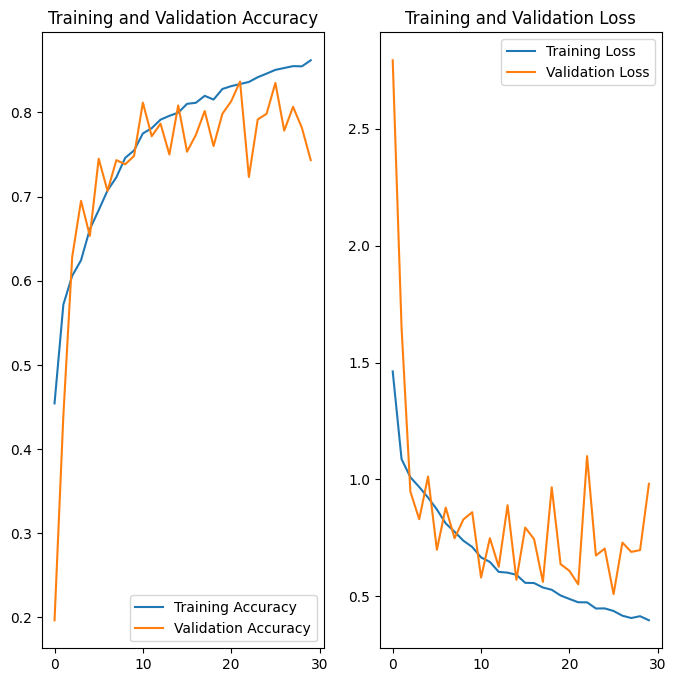

In [30]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()